# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [2]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')

# Download the files
download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')

Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl


In [3]:
# Load the training data
with open('X_train.pkl','rb') as f: X_train = pickle.load(f)
with open('y_train.pkl','rb') as f: y_train = pickle.load(f)
with open('X_test.pkl','rb')  as f: X_test  = pickle.load(f)


print(f"Loaded {len(X_train)} training images")
print(f"Loaded {len(y_train)}")
print(f"Sample image shape: {getattr(X_train[0], 'shape', 'unknown')}")
print(f"First label type/len: {type(y_train[0])}, {len(y_train[0]) if hasattr(y_train[0],'__len__') else 'n/a'}")
print("Example first label item (up to 3 boxes):", (y_train[0][:3] if hasattr(y_train[0],'__len__') else y_train[0]))

Loaded 496 training images
Loaded 496
Sample image shape: (418, 466, 3)
First label type/len: <class 'numpy.ndarray'>, 1
Example first label item (up to 3 boxes): [[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [4]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.imshow(image)
    height, width = image.shape[:2]

    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box

        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height

        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2

        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.axis('off')
    return ax

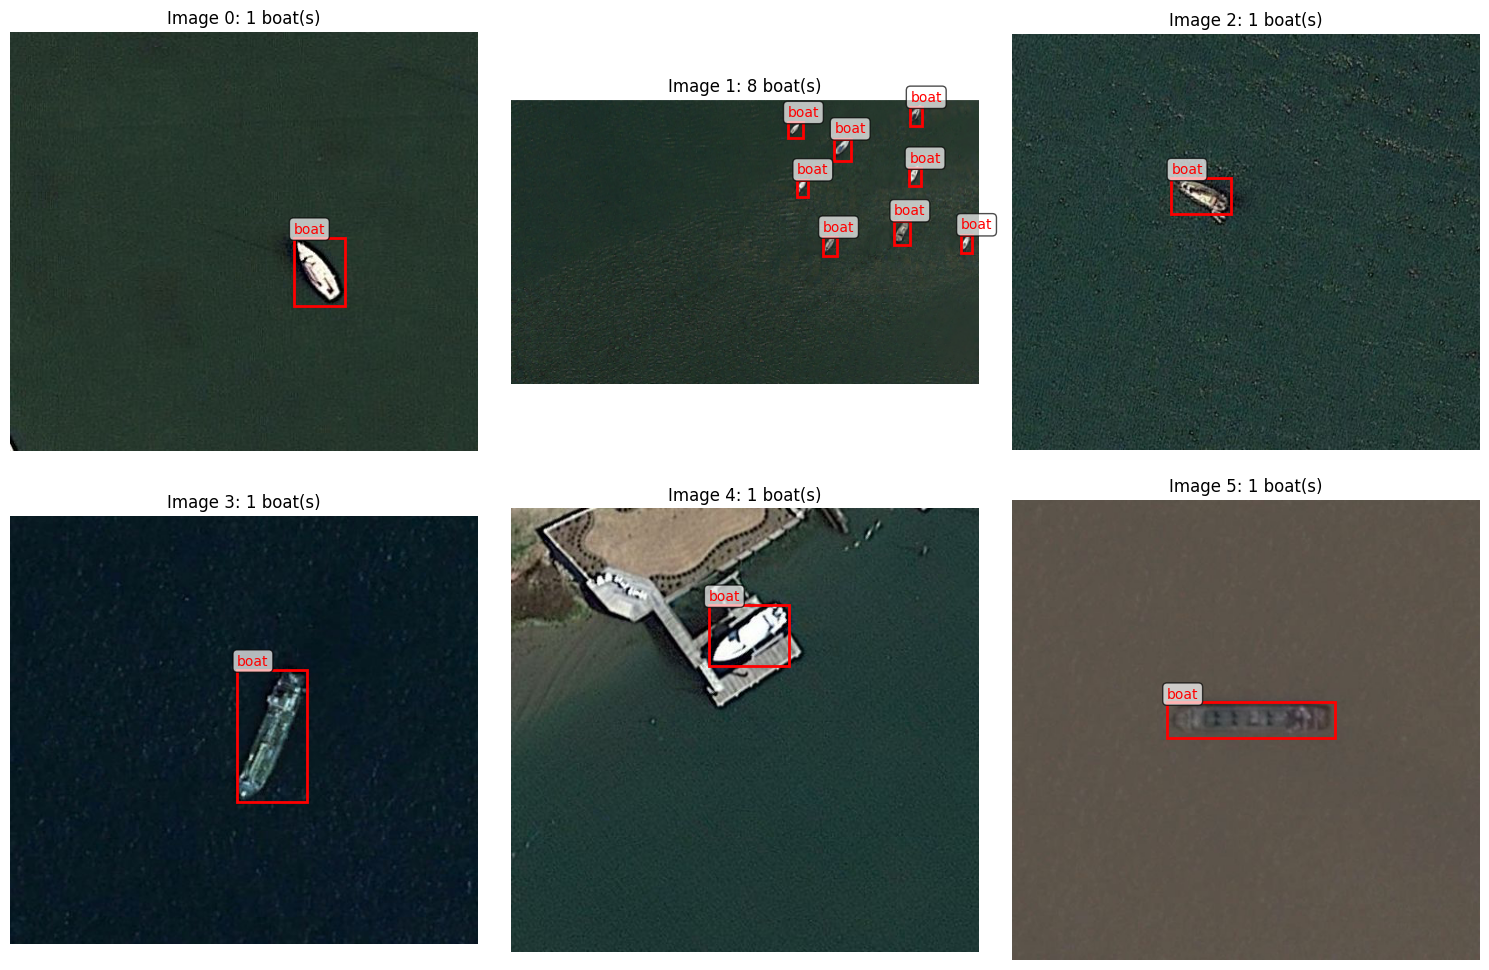

In [5]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X_train[i], y_train[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y_train[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [6]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.0 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded successfully!


In [9]:
from sklearn.model_selection import train_test_split
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(len(X_train2), len(X_val))
print(len(y_train2), len(y_val))

396 100
396 100


In [10]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X_train2[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 /content/temp_sample.png: 608x640 (no detections), 44.5ms
Speed: 11.3ms preprocess, 44.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
Pre-trained model detected 0 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [ ]:
# Your code here
# Fine-tune the YOLO model


In [11]:
def labels_to_yolo_lines(boxes, img_width=640, img_height=480):
    lines = []
    for box in boxes:
        cls, x_min, y_min, x_max, y_max = box
        # conversion en coordonnées normalisées YOLO
        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        lines.append(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return lines

In [12]:
import numpy as np
from pathlib import Path
from PIL import Image

# --- util ---
def to_uint8_rgb(arr):
    arr = np.asarray(arr)
    if arr.dtype != np.uint8:
        # suppose arr in [0,1] ou [0,255]
        if arr.max() <= 1.0:
            arr = (arr * 255.0).clip(0,255).astype(np.uint8)
        else:
            arr = arr.clip(0,255).astype(np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.shape[-1] == 4:
        arr = arr[..., :3]
    return arr

def _is_normalized(vals):
    return np.all((vals >= 0.0) & (vals <= 1.0))

def labels_to_yolo_lines(boxes, img_shape=None):
    """
    Accepte plusieurs formats d'entrée pour `boxes`:
      - YOLO normalisé: [cls, cx, cy, w, h]  -> passe-plat
      - YOLO en pixels: [cls, cx, cy, w, h]  -> normalise avec img_shape
      - XYXY pixels   : [cls, xmin, ymin, xmax, ymax] -> convertit en YOLO normalisé
    """
    boxes = np.asarray(boxes, dtype=float)
    if boxes.ndim == 1:
        boxes = boxes[None, :]

    H = W = None
    if img_shape is not None:
        H, W = img_shape[:2]

    lines = []
    for b in boxes:
        if len(b) < 5:
            # ignore silencieusement
            continue

        cls = int(round(b[0]))
        v = b[1:5]

        # cas 1: déjà YOLO normalisé (cx,cy,w,h in [0,1])
        if _is_normalized(v):
            cx, cy, bw, bh = v

        else:
            # si pas normalisé:
            if W is None or H is None:
                raise ValueError("labels_to_yolo_lines: img_shape requis pour normaliser des valeurs en pixels.")


            xmin, ymin, xmax, ymax = v
            if xmax > xmin and ymax > ymin:
                bw = xmax - xmin
                bh = ymax - ymin
                cx = xmin + bw/2
                cy = ymin + bh/2
            else:
                # suppose YOLO en pixels (cx,cy,w,h)
                cx, cy, bw, bh = v

            # normaliser
            cx, cy, bw, bh = cx / W, cy / H, bw / W, bh / H

        # clamp léger
        cx = float(np.clip(cx, 0, 1))
        cy = float(np.clip(cy, 0, 1))
        bw = float(np.clip(bw, 0, 1))
        bh = float(np.clip(bh, 0, 1))

        lines.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")
    return lines


dataset_root = Path('submarine_dataset')
for split in ['train','val']:
    (dataset_root/split/'images').mkdir(parents=True, exist_ok=True)
    (dataset_root/split/'labels').mkdir(parents=True, exist_ok=True)

# TRAIN
for idx in range(len(X_train2)):
    img_np = to_uint8_rgb(X_train2[idx])
    img = Image.fromarray(img_np).convert("RGB")
    stem = f"img_{idx:06d}"
    img.save(dataset_root/'train'/'images'/f"{stem}.jpg", quality=95)

    lines = labels_to_yolo_lines(y_train2[idx], img_shape=img_np.shape)
    (dataset_root/'train'/'labels'/f"{stem}.txt").write_text("\n".join(lines))

# VAL
for idx in range(len(X_val)):
    img_np = to_uint8_rgb(X_val[idx])
    img = Image.fromarray(img_np).convert("RGB")
    stem = f"img_{idx:06d}"
    img.save(dataset_root/'val'/'images'/f"{stem}.jpg", quality=95)

    lines = labels_to_yolo_lines(y_val[idx], img_shape=img_np.shape)
    (dataset_root/'val'/'labels'/f"{stem}.txt").write_text("\n".join(lines))

print("✅ Dataset re-prepared.")
print(f"  Train: {len(X_train2)} images")
print(f"  Val:   {len(X_val)} images")

✅ Dataset re-prepared.
  Train: 396 images
  Val:   100 images


In [13]:
# Create dataset config file for YOLO (submarines)
from pathlib import Path

dataset_root = Path('submarine_dataset')

config = f"""
path: {dataset_root.absolute()}
train: train/images
val: val/images

nc: 1
names: ['submarine']
"""

with open('submarine.yaml', 'w') as f:
    f.write(config)

print('✅ Config file created: submarine.yaml')

✅ Config file created: submarine.yaml


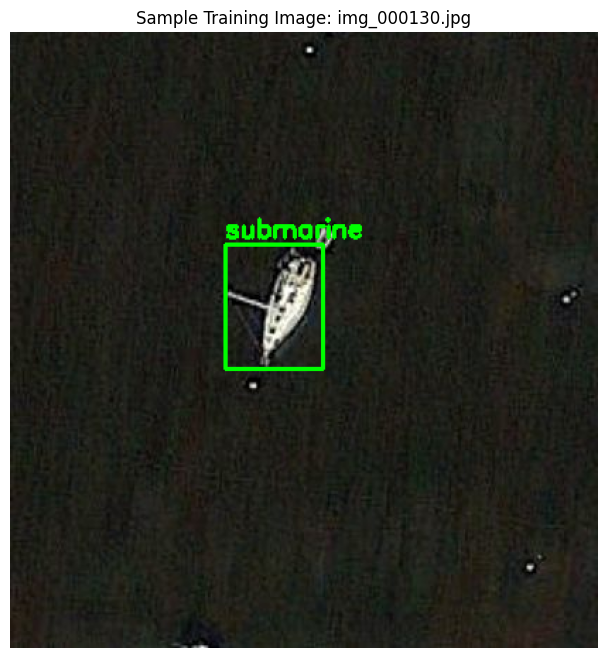

In [14]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random


dataset_root = Path('submarine_dataset')

# Choisir une image aléatoire dans le train
train_images = list((dataset_root / 'train' / 'images').glob('*.jpg'))
sample_img = random.choice(train_images)

# Trouver le fichier label correspondant
sample_label = dataset_root / 'train' / 'labels' / sample_img.name.replace('.jpg', '.txt')

# Lire l'image
img = cv2.imread(str(sample_img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Lire et dessiner les bounding boxes YOLO
if sample_label.exists():
    with open(sample_label) as f:
        for line in f:
            cls, x_c, y_c, width, height = map(float, line.strip().split())

            # Conversion coordonnées normalisées → pixels
            x_c, y_c, width, height = x_c * w, y_c * h, width * w, height * h
            x1 = int(x_c - width / 2)
            y1 = int(y_c - height / 2)
            x2 = int(x_c + width / 2)
            y2 = int(y_c + height / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"submarine", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"Sample Training Image: {sample_img.name}")
plt.axis('off')
plt.show()

In [16]:
from ultralytics import YOLO


model_ft = YOLO('yolov8n.pt')


# Entraîner sur ton dataset
results = model_ft.train(
    data='submarine.yaml',     #  fichier de config
    epochs=150,
    imgsz=640,
    batch=8,
    name='submarine_detector', # nom du run dans runs/detect/
    patience=25,
    save=True,
    verbose=True,
    device="gpu",
    pretrained = True
)

print('🚀 Training complete!')

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:gpu (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=submarine.yaml, degrees=0.0, deterministic=True, device=gpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=submarine_detector2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=25, perspective=0.0, plots=True, pose=1

In [18]:
from pathlib import Path
from ultralytics import YOLO
import os

# 1) Où suis-je ?
print("cwd:", os.getcwd())

# 2) Qu'est-ce qu'il y a dans runs/detect ?
runs_dir = Path("runs/detect")
if not runs_dir.exists():
    print("⚠️ Pas de dossier runs/detect ici. Tu es peut-être dans un autre répertoire ou une nouvelle session Colab.")
else:
    print("Sous-dossiers runs/detect :", [p.name for p in runs_dir.iterdir() if p.is_dir()])

# 3) Chercher tous les best.pt disponibles (où qu'ils soient sous runs/)
cands = sorted(Path("runs").rglob("best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
print("best.pt trouvés (du plus récent au plus ancien) :", [str(p) for p in cands[:5]])

# 4) Charger le plus récent si possible, sinon tenter last.pt
ckpt_path = None
if cands:
    ckpt_path = str(cands[0])
else:
    lasts = sorted(Path("runs").rglob("last.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
    if lasts:
        ckpt_path = str(lasts[0])
        print("⚠️ best.pt introuvable, on prend last.pt :", ckpt_path)

if ckpt_path is None:
    raise FileNotFoundError("Aucun best.pt/last.pt trouvé sous runs/. Relance l'entraînement ou vérifie le répertoire.")

print("→ On charge :", ckpt_path)
model_ft = YOLO(ckpt_path)

# 5) Évaluer
metrics = model_ft.val(data='submarine.yaml')
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

cwd: /content
Sous-dossiers runs/detect : ['submarine_detector', 'submarine_detector2']
best.pt trouvés (du plus récent au plus ancien) : ['runs/detect/submarine_detector2/weights/best.pt', 'runs/detect/submarine_detector/weights/best.pt']
→ On charge : runs/detect/submarine_detector2/weights/best.pt
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1567.9±657.8 MB/s, size: 37.7 KB)
val: Scanning /content/submarine_dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 114.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.9it/s 2.4s
                   all        100        160      0.924      0.834      0.892      0.655
Speed: 4.2ms preprocess, 8.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved 

In [22]:
model_ft_best = YOLO('runs/detect/submarine_detector2/weights/best.pt')
metrics = model_ft_best.val(data='submarine.yaml')
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1220.6±506.9 MB/s, size: 64.0 KB)
val: Scanning /content/submarine_dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 68.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.9it/s 3.7s
                   all        100        160      0.924      0.834      0.892      0.655
Speed: 9.0ms preprocess, 6.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /content/runs/detect/val3
mAP50: 0.892
Precision: 0.924
Recall: 0.834


## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [23]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')

    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model_ft_best.predict(source='temp_test.png', conf=0.25, verbose=False)

    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())

        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })

    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 411


In [24]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.884303  0.565450  0.435535  0.161774   
1         0        1         0    0.644445  0.453061  0.486797  0.038698   
2         1        0         0    0.381641  0.721655  0.387697  0.034652   
3         2        0         0    0.905465  0.482596  0.425385  0.301378   
4         3        0         0    0.881641  0.358956  0.361313  0.242064   
5         4        0         0    0.915347  0.462875  0.412796  0.123643   
6         5        0         0    0.923755  0.433877  0.451375  0.356017   
7         6        0         0    0.916895  0.579154  0.557340  0.463371   
8         7        0         0    0.739460  0.482996  0.353019  0.623489   
9         8        0         0    0.909184  0.592988  0.481206  0.171291   

     height  
0  0.135665  
1  0.039706  
2  0.023893  
3  0.220178  
4  0.126948  
5  0.446066  
6  0

In [25]:
from google.colab import files

# Télécharger le fichier
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>